<a id='top'></a> 
# Healthcare Provider Fraud Detection 

#### Table of Contents
- [Background](#background)
- [Data Import](#import)
- [Exploratory Analysis](#eda)
- [Data Cleaning](#clean)
- [Feature Engineering](#engineer)
- [Modeling](#model)



## Background <a id='background'></a>

[Kaggle Compitition](https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis)

[example](https://www.kaggle.com/rohitrox/medical-provider-fraud-detection/log)


## Data Import <a id='import'></a>

[Back To Top](#top)

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import missingno as msno
import apyori as apriori

In [2]:
file_list = ["Test-1542969243754.csv",
             "Test_Beneficiarydata-1542969243754.csv",
             "Test_Inpatientdata-1542969243754.csv",
             "Test_Outpatientdata-1542969243754.csv",
             "Train-1542865627584.csv",
             "Train_Beneficiarydata-1542865627584.csv",
             "Train_Inpatientdata-1542865627584.csv",
             "Train_Outpatientdata-1542865627584.csv"]

clean = str.maketrans("","","-0123456789")
file_names = [x.translate(clean).replace(".csv","") for x in file_list]


def custom_import(train_only = False):
    '''
    
    '''
    
    name_file_dict = dict()
    PATH          = "./data/"
    
    for name, file in zip(file_names,file_list):
        name_file_dict[name] = pd.read_csv(PATH+file)

    if train_only:
        return_dict = {key: value for key, value in name_file_dict.items() if key.startswith("Train")}
        return return_dict
    else:
        return name_file_dict
    
        
    
data_dict = custom_import(train_only=False)

In [6]:
prov_key = data_dict['Train']
prov_key = prov_key.replace({"No":0,"Yes":1})

Bene_data = data_dict['Train_Beneficiarydata']

dfs = [data_dict['Train_Inpatientdata'],data_dict['Train_Outpatientdata']]
keys = ['Inpatient',"Outpatient"]
Train_Patientdata = pd.concat([df.assign(Source=key).reset_index() for key, df in zip(keys,dfs)],axis=0, ignore_index=True).drop('index',axis=1)

## Exploratory Analysis <a id='eda'></a>

[Back To Top](#top)

Provider Data

In [8]:
prov_key

,Provider,PotentialFraud
0,PRV51001,0
1,PRV51003,1
2,PRV51004,0
3,PRV51005,1
4,PRV51007,0
...,...,...
5405,PRV57759,0
5406,PRV57760,0
5407,PRV57761,0
5408,PRV57762,0


In [10]:
print("Provider Key Information")
print("-"*30)
print("Number of unique Providers: {}\n".format(prov_key.Provider.nunique()))
print("Fraud counts: \n{}\n".format(prov_key.PotentialFraud.value_counts()))
fraud_counts = data_dict['Train'].PotentialFraud.value_counts()[1]
print("Percent Potential Fraud: {:.3}\n".format(100* fraud_counts/ prov_key.PotentialFraud.count()))

Provider Key Information
------------------------------
Number of unique Providers: 5410

Fraud counts: 
0    4904
1     506
Name: PotentialFraud, dtype: int64

Percent Potential Fraud: 9.35



In [83]:
data_dict['Train_Beneficiarydata'].head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [84]:
print("Beneficiary Data")
print(data_dict['Train_Beneficiarydata'].shape)
print("-"*30)
print("Number of unique Beneficiary ID: {}\n".format(data_dict['Train_Beneficiarydata'].BeneID.nunique()))
print( "Most columns are condition flags: \n{}".format(data_dict['Train_Beneficiarydata'].columns.values))

Beneficiary Data
(138556, 25)
------------------------------
Number of unique Beneficiary ID: 138556

Most columns are condition flags: 
['BeneID' 'DOB' 'DOD' 'Gender' 'Race' 'RenalDiseaseIndicator' 'State'
 'County' 'NoOfMonths_PartACov' 'NoOfMonths_PartBCov'
 'ChronicCond_Alzheimer' 'ChronicCond_Heartfailure'
 'ChronicCond_KidneyDisease' 'ChronicCond_Cancer'
 'ChronicCond_ObstrPulmonary' 'ChronicCond_Depression'
 'ChronicCond_Diabetes' 'ChronicCond_IschemicHeart'
 'ChronicCond_Osteoporasis' 'ChronicCond_rheumatoidarthritis'
 'ChronicCond_stroke' 'IPAnnualReimbursementAmt' 'IPAnnualDeductibleAmt'
 'OPAnnualReimbursementAmt' 'OPAnnualDeductibleAmt']


In [85]:
data_dict['Train_Inpatientdata']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Source
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,Inpatient
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,Inpatient
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,Inpatient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000,PHY345332,PHY319565,NaN,2009-09-28,...,70704,2869,4148,9904.0,NaN,NaN,NaN,NaN,NaN,Inpatient
40470,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000,PHY342806,PHY365497,NaN,2009-11-03,...,4254,5990,NaN,8605.0,NaN,NaN,NaN,NaN,NaN,Inpatient
40471,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000,PHY423220,PHY332752,NaN,2009-11-18,...,71590,V4502,NaN,9390.0,NaN,NaN,NaN,NaN,NaN,Inpatient
40472,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000,PHY353156,NaN,NaN,2009-12-17,...,0414,41400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient


In [86]:
print("Inpatient Data")
print(data_dict['Train_Inpatientdata'].shape)
print("-"*30)
print("Number of unique ClaimID ID: {}\n".format(data_dict['Train_Inpatientdata'].ClaimID.nunique()))
print("Most columns are diagnosis, not pivoted, flags: \n{}".format(data_dict['Train_Inpatientdata'].columns.values))

Inpatient Data
(40474, 31)
------------------------------
Number of unique ClaimID ID: 40474

Most columns are diagnosis, not pivoted, flags: 
['BeneID' 'ClaimID' 'ClaimStartDt' 'ClaimEndDt' 'Provider'
 'InscClaimAmtReimbursed' 'AttendingPhysician' 'OperatingPhysician'
 'OtherPhysician' 'AdmissionDt' 'ClmAdmitDiagnosisCode'
 'DeductibleAmtPaid' 'DischargeDt' 'DiagnosisGroupCode'
 'ClmDiagnosisCode_1' 'ClmDiagnosisCode_2' 'ClmDiagnosisCode_3'
 'ClmDiagnosisCode_4' 'ClmDiagnosisCode_5' 'ClmDiagnosisCode_6'
 'ClmDiagnosisCode_7' 'ClmDiagnosisCode_8' 'ClmDiagnosisCode_9'
 'ClmDiagnosisCode_10' 'ClmProcedureCode_1' 'ClmProcedureCode_2'
 'ClmProcedureCode_3' 'ClmProcedureCode_4' 'ClmProcedureCode_5'
 'ClmProcedureCode_6' 'Source']


In [87]:
data_dict['Train_Outpatientdata']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,Source
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409,Outpatient
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380,Outpatient
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947,Outpatient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517732,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,2163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
517733,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,07041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
517734,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,V570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
517735,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient


In [4]:
print("Outpatient Data")
print(data_dict['Train_Outpatientdata'].shape)
print("-"*30)
print("Number of unique ClaimID ID: {}\n".format(data_dict['Train_Outpatientdata'].ClaimID.nunique()))
print("Most columns are diagnosis, not pivoted, flags: \n{}".format(data_dict['Train_Outpatientdata'].columns.values))

Outpatient Data
(517737, 27)
------------------------------
Number of unique ClaimID ID: 517737

Most columns are diagnosis, not pivoted, flags: 
['BeneID' 'ClaimID' 'ClaimStartDt' 'ClaimEndDt' 'Provider'
 'InscClaimAmtReimbursed' 'AttendingPhysician' 'OperatingPhysician'
 'OtherPhysician' 'ClmDiagnosisCode_1' 'ClmDiagnosisCode_2'
 'ClmDiagnosisCode_3' 'ClmDiagnosisCode_4' 'ClmDiagnosisCode_5'
 'ClmDiagnosisCode_6' 'ClmDiagnosisCode_7' 'ClmDiagnosisCode_8'
 'ClmDiagnosisCode_9' 'ClmDiagnosisCode_10' 'ClmProcedureCode_1'
 'ClmProcedureCode_2' 'ClmProcedureCode_3' 'ClmProcedureCode_4'
 'ClmProcedureCode_5' 'ClmProcedureCode_6' 'DeductibleAmtPaid'
 'ClmAdmitDiagnosisCode']


Since inpatent and outpatient are mostly the same, we should determine if they are suitable to be combined.

In [89]:
inpat = set(data_dict['Train_Inpatientdata'].columns.values)
outpat = set(data_dict['Train_Outpatientdata'].columns.values)
print("Columns in Inpatient, not in Outpatient: {}".format(inpat.symmetric_difference(outpat)))

Columns in Inpatient, not in Outpatient: {'DischargeDt', 'DiagnosisGroupCode', 'AdmissionDt'}


In [3]:
dfs = [data_dict['Train_Inpatientdata'],data_dict['Train_Outpatientdata']]
keys = ['Inpatient',"Outpatient"]
Train_Patientdata = pd.concat([df.assign(Source=key).reset_index() for key, df in zip(keys,dfs)],axis=0, ignore_index=True).drop('index',axis=1)
Train_Patientdata.Source.value_counts()

Outpatient    517737
Inpatient      40474
Name: Source, dtype: int64

What do DiagnosisCodes look like? Are there different codes between Inpatient and outpatient?

In [5]:
inpatient_diag_codes = set(Train_Patientdata \
                                 .loc[Train_Patientdata['Source']=='Inpatient'] \
                                 .filter(like = 'ClmDiagnosisCode_') \
                                 .astype(str).to_numpy().flatten())
outpatient_diag_codes = set(Train_Patientdata \
                                  .loc[Train_Patientdata['Source']=='Outpatient'] \
                                  .filter(like = 'ClmDiagnosisCode_') \
                                  .astype(str).to_numpy().flatten())

print("There are {} unique diagnositic codes across both sets including NA" \
      .format(len(inpatient_diag_codes.union(outpatient_diag_codes))))

print("There are {} total inpatient diagnositic codes including NA." \
      .format(len(inpatient_diag_codes)))
print("There are {} total outpatient diagnositic codes including NA." \
      .format(len(outpatient_diag_codes)))



print("There are {} codes unique to Inpatient" \
      .format(len(inpatient_diag_codes.difference(outpatient_diag_codes))))
print("There are {} codes unique to Outpatient" \
      .format(len(outpatient_diag_codes.difference(inpatient_diag_codes))))
print("There are {} shared codes" \
      .format(len(outpatient_diag_codes.intersection(inpatient_diag_codes))))


There are 11015 unique diagnositic codes across both sets including NA
There are 4717 total inpatient diagnositic codes including NA.
There are 10847 total outpatient diagnositic codes including NA.
There are 168 codes unique to Inpatient
There are 6298 codes unique to Outpatient
There are 4549 shared codes


Inpatients claims show a linear increase from 0 to 10 diagnositic codes, there appears to be an extremely large discontinutity at 9 diagnositc codes. Perhaps this has to do with the data collection method?

Note: There are an order of magnitude more outpatient claims than inpatient claims.

array([<AxesSubplot:title={'center':'Inpatient'}>,
       <AxesSubplot:title={'center':'Outpatient'}>], dtype=object)

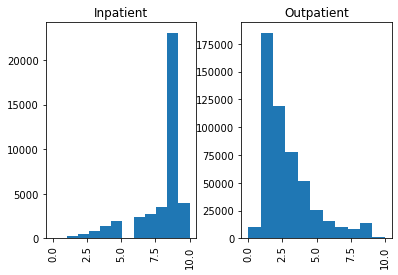

In [23]:
Train_Patientdata \
    .filter(like ="ClmDiagnosisCode_") \
    .count(axis=1) \
    .hist(by=Train_Patientdata["Source"], sharex=True,bins = 11)


Most inpatient claims have 0-2 procedure codes, almost all outpatient claims have 0, which is expected given that they are outpatients.

Note: There are an order of magnitude more outpatient claims than inpatient claims.

In [33]:
inpatient_proced_codes = set(Train_Patientdata \
                                 .loc[Train_Patientdata['Source']=='Inpatient'] \
                                 .filter(like = 'ClmProcedureCode') \
                                 .astype(str).to_numpy().flatten())
outpatient_proced_codes = set(Train_Patientdata \
                                  .loc[Train_Patientdata['Source']=='Outpatient'] \
                                  .filter(like = 'ClmProcedureCode') \
                                  .astype(str).to_numpy().flatten())

print("There are {} unique Procedure codes across both sets including NA" \
      .format(len(inpatient_proced_codes.union(outpatient_proced_codes))))

print("There are {} total inpatient Procedure codes including NA." \
      .format(len(inpatient_proced_codes)))
print("There are {} total outpatient Procedure codes including NA." \
      .format(len(outpatient_proced_codes)))



print("There are {} codes unique to Inpatient" \
      .format(len(inpatient_proced_codes.difference(outpatient_proced_codes))))
print("There are {} codes unique to Outpatient" \
      .format(len(outpatient_proced_codes.difference(inpatient_proced_codes))))
print("There are {} shared codes" \
      .format(len(outpatient_proced_codes.intersection(inpatient_proced_codes))))

There are 1325 unique Procedure codes across both sets including NA
There are 1322 total inpatient Procedure codes including NA.
There are 105 total outpatient Procedure codes including NA.
There are 1220 codes unique to Inpatient
There are 3 codes unique to Outpatient
There are 102 shared codes


array([<AxesSubplot:title={'center':'Inpatient'}>,
       <AxesSubplot:title={'center':'Outpatient'}>], dtype=object)

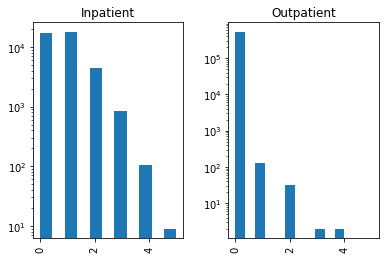

In [25]:
Train_Patientdata \
    .filter(like ="ClmProcedureCode") \
    .count(axis=1) \
    .hist(by=Train_Patientdata["Source"], sharex=True,bins = 11, log = True)


In [34]:
Train_Patientdata.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Source'],
      dtype='object')

In [37]:
Train_Patientdata["DiagnosisCodeCount"] = Train_Patientdata.filter(like="ClmDiagnosisCode_").count(axis=1)
Train_Patientdata["ProcedureCodeCount"] = Train_Patientdata.filter(like="ClmProcedureCode_").count(axis=1)

array([[<AxesSubplot:title={'center':'n_claims'}>,
        <AxesSubplot:title={'center':'n_provider'}>],
       [<AxesSubplot:title={'center':'avg_reimbursed'}>,
        <AxesSubplot:title={'center':'avg_deductable'}>],
       [<AxesSubplot:title={'center':'avg_diag_count'}>,
        <AxesSubplot:title={'center':'avg_prcd_count'}>]], dtype=object)

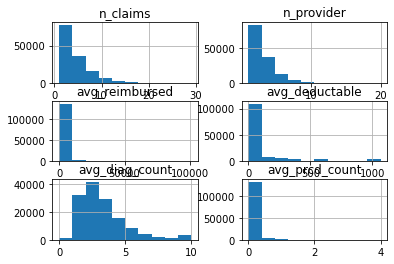

In [46]:
Train_Patientdata.groupby("BeneID").agg(n_claims = ("ClaimID","nunique"),
                                        n_provider = ("Provider","nunique"),
                                        avg_reimbursed = ("InscClaimAmtReimbursed","mean"),
                                        avg_deductable = ("DeductibleAmtPaid","mean"),
                                        avg_diag_count = ("DiagnosisCodeCount",'mean'),
                                        avg_prcd_count = ("ProcedureCodeCount",'mean')
                                       ).hist()

In [4]:
Bene_data = data_dict['Train_Beneficiarydata']

Bene_data.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')

In [47]:
print("There are {} patients".format(Bene_data.shape[0]))
print("{:.2f}% of patients have not died".format(100* Bene_data[Bene_data.DOD.isna()].shape[0] / Bene_data.shape[0]))


There are 138556 patients
98.97% of patients have not died


Considering the abundance and data, especially without a data dictionary, 1 appears to be the condition "present" value and 2 is the condition "absent" value. This feels intuitive since only conditions like Diabetes, IschmicHeart (clogged arteries) are more common than absent in the dataset. 

This is also consistant with more rare conditions such as cancer, depression, and ObstrPulmanary, where 2 has a higher count than 1. 

In [103]:
[Bene_data[x].value_counts(dropna=False) for x in Bene_data.filter(like="ChronicCond_").columns]

[2    92530
 1    46026
 Name: ChronicCond_Alzheimer, dtype: int64,
 2    70154
 1    68402
 Name: ChronicCond_Heartfailure, dtype: int64,
 2    95277
 1    43279
 Name: ChronicCond_KidneyDisease, dtype: int64,
 2    121935
 1     16621
 Name: ChronicCond_Cancer, dtype: int64,
 2    105697
 1     32859
 Name: ChronicCond_ObstrPulmonary, dtype: int64,
 2    89296
 1    49260
 Name: ChronicCond_Depression, dtype: int64,
 1    83391
 2    55165
 Name: ChronicCond_Diabetes, dtype: int64,
 1    93644
 2    44912
 Name: ChronicCond_IschemicHeart, dtype: int64,
 2    100497
 1     38059
 Name: ChronicCond_Osteoporasis, dtype: int64,
 2    102972
 1     35584
 Name: ChronicCond_rheumatoidarthritis, dtype: int64,
 2    127602
 1     10954
 Name: ChronicCond_stroke, dtype: int64]

Exploring association rule for chronic conditions

In [22]:
Bene_data.filter(like="ChronicCond_").head()

,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,1,2,1,2,2,1,1,1,2,1,1
1,2,2,2,2,2,2,2,2,2,2,2
2,1,2,2,2,2,2,2,1,2,2,2
3,1,1,2,2,2,2,1,1,1,1,2
4,2,2,2,2,1,2,1,2,2,2,2


In [49]:
# Add renal disease indicator

chronic_conds = Bene_data.filter(like="ChronicCond_").astype(str)
chronic_conds = chronic_conds.loc[:,:] \
                             .replace("1",pd.Series(chronic_conds.columns, chronic_conds.columns)) \
                             .replace("2",np.NaN)\
                             .values.tolist()
                            
cleaned_chronic_conds = [[i for i in x if pd.isnull(i)==False] for x in chronic_conds]
cleaned_chronic_conds = [x for x in cleaned_chronic_conds if x != []]

In [57]:
association_rules = apriori.apriori(cleaned_chronic_conds, min_length=2)
                                    #, min_support=0.2, min_confidence=0.2, min_lift=2, min_length=2)
association_results = list(association_rules)

It might be more useful to make a key of diagnosis/procedures based on chronic conditions and then get the percentage prevalence for the pair.

In [75]:
claim_bene = Train_Patientdata.merge(Bene_data,on="BeneID")
claim_bene.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Source', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', '

In [94]:
filter_cols = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6','RenalDiseaseIndicator','ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

renamed_cols = ['RenalDiseaseIndicator','ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']


prevalence_lookup = claim_bene.filter(filter_cols, axis=1)

prevalence_lookup


prevalence_lookup = prevalence_lookup.loc[:,:] \
                             .replace(1,pd.Series(prevalence_lookup.columns, prevalence_lookup.columns)) \
                             .replace(2,np.NaN)

pd.melt()


,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,...,NaN,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
1,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
2,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,...,NaN,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
3,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
4,78969,78701,V5866,59389,2449,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN
558207,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN
558208,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN
558209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN


In [ ]:
# need some graphics regarding information

# IF YOU are treated by a suspect provider are you more liely to have higher codes?

## Data Cleaning <a id='clean'></a>

[Back To Top](#top)

In [18]:
claims.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Source', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', '

### [Claim group codes](https://www.cms.gov/icd10m/version38-0-R1-fullcode-cms/fullcode_cms/P0002.html)

### [Diagnosis and Procedure Codes](https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/codes)

In [21]:
claims.ClaimEndDt

0         2009-04-18
1         2009-09-06
2         2009-02-01
3         2009-11-04
4         2009-10-29
             ...    
558206    2009-06-04
558207    2009-02-08
558208    2009-07-29
558209    2009-04-16
558210    2009-09-20
Name: ClaimEndDt, Length: 558211, dtype: object

In [25]:
claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,2,1,1,36000,3204,60,70,1
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,...,2,1,2,2,2,24000,2136,450,200,1
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,...,2,1,2,2,2,19000,1068,100,20,1
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,...,2,1,1,2,2,17000,1068,1050,540,1
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,...,1,1,1,1,2,27000,2136,450,160,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE154147,CLM394122,2009-06-02,2009-06-04,PRV54050,500,PHY317497,NaN,PHY317497,NaN,...,2,1,1,2,2,0,0,890,120,0
558207,BENE154687,CLM184358,2009-02-08,2009-02-08,PRV54302,3300,PHY376238,PHY376238,NaN,NaN,...,1,1,2,1,2,0,0,4400,220,0
558208,BENE157378,CLM460770,2009-07-09,2009-07-29,PRV51577,2100,PHY338096,NaN,NaN,NaN,...,1,1,2,2,2,0,0,14240,2810,0
558209,BENE158295,CLM306999,2009-04-16,2009-04-16,PRV53083,10,PHY416646,NaN,NaN,NaN,...,1,1,1,1,2,0,0,640,350,0


In [22]:
print(claims.DiagnosisGroupCode.value_counts())
print(claims.filter(like="ClmP"))

882    179
884    174
166    168
183    165
939    163
      ... 
927      1
768      1
955      1
765      1
934      1
Name: DiagnosisGroupCode, Length: 736, dtype: int64
        ClmProcedureCode_1  ClmProcedureCode_2  ClmProcedureCode_3  \
0                      NaN                 NaN                 NaN   
1                      NaN                 NaN                 NaN   
2                   7769.0              5849.0                 NaN   
3                   9338.0                 NaN                 NaN   
4                   8154.0                 NaN                 NaN   
...                    ...                 ...                 ...   
558206                 NaN                 NaN                 NaN   
558207                 NaN                 NaN                 NaN   
558208                 NaN                 NaN                 NaN   
558209                 NaN                 NaN                 NaN   
558210                 NaN                 NaN           

In [ ]:
def bene_clean(bene_data):
    
    #Replace Chronic Diseases & Renal Indicator with 0/1 notation.
    bene_data = bene_data.loc[:,:].replace({2:0,"Y":1})
    
    # Shifting gender to 0/1 instead of 1/2
    bene_data["Gender"] = bene_data["Gender"] - 1
    
    return(bene_data)


def claim_clean(claim_data):
    

    
def drop_identifiers(data):
    dropped_data = data.drop(labels = ['BeneID','ClaimID','Provider','PotentialFraud'], axis =1) 
    target = data['PotentialFraud']
    return (dropped_data, target)


## Feature Engineering <a id='engineer'></a>

[Back To Top](#top)

In [9]:
def bene_feat(bene_data, dummify = False):
    chronic_cols = ['RenalDiseaseIndicator','ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
                   'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
                   'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
                   'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
                   'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                   'ChronicCond_stroke']
    
    # age
    bene_data['age_infered'] = ((pd.to_datetime(Bene_data['DOD']).max() - pd.to_datetime(Bene_data["DOB"])).dt.days / 365)
    
    # Death Flag
    bene_data['death_flag'] = bene_data['DOD'].isnull().astype(int).value_counts()
    
    # Drop DOB and DOD because its not easy to model
    bene_data = bene_data.drop(labels = ['DOB','DOD'], axis = 1)
    
    # Count of Chronic conditions
    bene_data['chronic_count'] = bene_data.filter(items = chronic_cols).sum(axis=1)
    
    
    if (dummify):
        
        for x in ["Race","State","County"]:
            bene_data[x] = pd.get_dummies(bene_data[x], prefix=x)

    return(bene_data)



def claim_feat(claim_data):
    
    # Count of Diagnosis Codes
    claim_data['diagnosis_count'] = claim_data.filter(like="ClmDiagnosisCode_").count(axis=1)
    
    # Count of Procedure Codes
    claim_data['procedure_count'] = claim_data.filter(like="ClmProcedureCode_").count(axis=1)
    
    # Length of claim
    claim_data['claim_length'] = (pd.to_datetime(claim_data['ClaimEndDt']) - pd.to_datetime(claim_data['ClaimStartDt'])).dt.days
    
    # Missing Physicians
    claim_data['phys_no_attending'] = claim_data["AttendingPhysician"].isna().astype(int)
    claim_data['phys_no_operating'] = claim_data["OperatingPhysician"].isna().astype(int)
    claim_data['phys_no_other']     = claim_data['OtherPhysician'].isna().astype(int)
    
    
    return(bene_data)

# Learning from the combined dataset

In [12]:
claims = Train_Patientdata.merge(Bene_data,on="BeneID")
claims = claims.merge(prov_key,on='Provider')

In [14]:
claims

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,2,1,1,36000,3204,60,70,1
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,...,2,1,2,2,2,24000,2136,450,200,1
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,...,2,1,2,2,2,19000,1068,100,20,1
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,...,2,1,1,2,2,17000,1068,1050,540,1
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,...,1,1,1,1,2,27000,2136,450,160,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE154147,CLM394122,2009-06-02,2009-06-04,PRV54050,500,PHY317497,NaN,PHY317497,NaN,...,2,1,1,2,2,0,0,890,120,0
558207,BENE154687,CLM184358,2009-02-08,2009-02-08,PRV54302,3300,PHY376238,PHY376238,NaN,NaN,...,1,1,2,1,2,0,0,4400,220,0
558208,BENE157378,CLM460770,2009-07-09,2009-07-29,PRV51577,2100,PHY338096,NaN,NaN,NaN,...,1,1,2,2,2,0,0,14240,2810,0
558209,BENE158295,CLM306999,2009-04-16,2009-04-16,PRV53083,10,PHY416646,NaN,NaN,NaN,...,1,1,1,1,2,0,0,640,350,0


In [ ]:
# pivot to provider?
# likelihhod value_countsles
# do i have to pivot? can I expand providers?


# Modeling <a id='model'></a>

[Back To Top](#top)

In [33]:
#from sklearn.feature_selection import SelectPercentile, SelectKBest, mutual_info_regression

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

#from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
train_idx, test_idx = train_test_split(claims.index, test_size=0.3, stratify=)

#### Need to implement upsampling
- [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [36]:
def first_pass_modeling(model, data, target):
    cv = StratifiedShuffleSplit()
    return cross_val_score(model,data,target,cv=cv, n_jobs=-1)




In [34]:
model_logit = LogisticRegression()
model_KNNC  = KNeighborsClassifier()
model_SVC   = SVC()
model_RF    = RandomForestClassifier()
model_GB    = GradientBoostingClassifier()
model_XGB   = XGBClassifier()
model_MLPC  = MLPClassifier()


In [40]:
claims.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Source', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', '

In [51]:
dummy_x = claims[['InscClaimAmtReimbursed','Gender','Race','IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt','OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']]
dummy_y = claims.PotentialFraud

In [55]:
for model in [model_logit,model_KNNC,model_SVC,model_RF,model_GB,model_XGB,model_MLPC]:
    print(first_pass_modeling(model,dummy_x, dummy_y))

[0.62224571 0.62226362 0.6227473  0.6228727  0.62319516 0.62308767
 0.62278313 0.62285479 0.62138583 0.62326681]


KeyboardInterrupt: 